# 3 Planet Fit with EMB

In [1]:
using PyPlot,JLD2
include("CGS.jl")

Main.CGS

In [2]:
rc("font",family="serif")
include("decompose_ttvs.jl")
include("extract_data.jl")

extract_data (generic function with 1 method)

In [3]:
function plot_ttvs(include_moon::Bool=false)
    pair_ttvs = decompose_ttvs(nplanet,ntrans,pbest_global) .* (24 * 60)
    n1,n2,n3 = ntrans
    mu1,P1,t01,ecos1,esin1 = pbest_global[1:5]
    mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
    mu3,P3,t03,ecos3,esin3 = pbest_global[11:15]
    time1 = collect(t01 .+ range(0,stop=n1-1,length=n1) .* P1)
    time2 = collect(t02 .+ range(0,stop=n2-1,length=n2) .* P2)
    tt1 = tt[1:n1]
    tt2 = tt[n1+1:n1+n2]
    ttsim1 = (ttmodel[1:n1].-t01)./365.25 #in years
    ttsim2 = (ttmodel[n1+1:n1+n2].-t02)./365.25 
    ttv1 = (tt1.-time1).* (24 * 60) #in minutes
    ttv2 = (tt2.-time2).* (24 * 60) 
    sigtt1 = sigtt[1:n1].* (24 * 60)
    sigtt2 = sigtt[n1+1:n1+n2].* (24 * 60)
    
    figsize=(10,8)
    subplot(211)
    plot(ttsim1,ttv1,linewidth=1.5,color="grey",label="Total")
    plot(ttsim1,pair_ttvs[1,2,1:n1],linewidth=1.25,label="Earth")
    plot(ttsim1,pair_ttvs[1,3,1:n1],linewidth=1.25,color="firebrick",label="Jupiter")
    errorbar(ttsim1,ttv1,sigtt1,fmt=".",color="black")
    ylabel("Venus TTVs [minutes]")
    subplot(212)
    plot(ttsim2,ttv2,linewidth=1.5,alpha=0.5,color="black",label="Total")
    plot(ttsim2,pair_ttvs[2,1,1:n2],linewidth=1.25,color="orange",label="Venus")
    plot(ttsim2,pair_ttvs[2,3,1:n2],linewidth=1.25,color="firebrick",label="Jupiter")
    if include_moon
        moon = moon_ttvs(ntrans,pbest_global) .* (24 * 60)
        plot(ttsim2,moon,linewidth=1.25,linestyle="--",color="purple")
        ylabel("Earth TTVs [minutes]")
    else
        ylabel("EMB TTVs [minutes]")
    end
    errorbar(ttsim2,ttv2,sigtt2,fmt=".",color="black")
    xlabel("Years Observed [N]")
    tight_layout()
    tick_params(direction="in")
#     legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)
#     savefig("name.eps")
end

plot_ttvs (generic function with 2 methods)

### Plot of simulated years observed vs TTVs

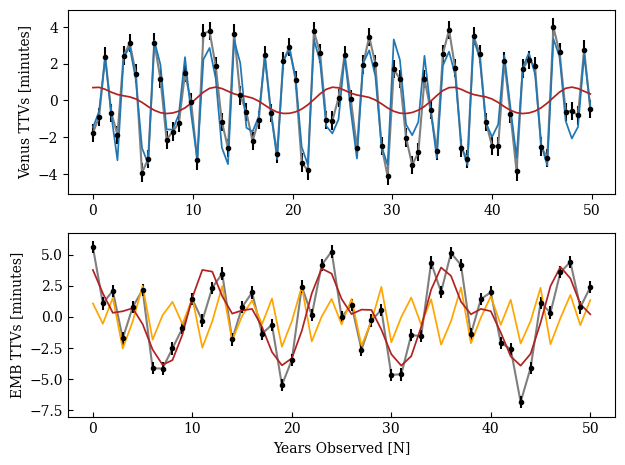

In [8]:
extract_data("OUTPUTS/p3_fittestparams.jld2")
extract_data("mcmc_testingresults.jld2")
plot_ttvs(false)

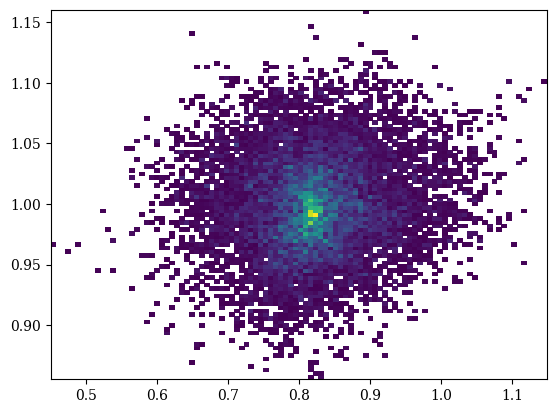

([NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [0.4503228447838222, 0.45730870171886545, 0.46429455865390873, 0.471280415588952, 0.4782662725239953, 0.48525212945903856, 0.4922379863940819, 0.49922384332912517, 0.5062097002641684, 0.5131955571992117  …  1.086035825872761, 1.093021682807804, 1.1000075397428475, 1.1069933966778907, 1.113979253612934, 1.1209651105479772, 1.1279509674830206, 1.1349368244180638, 1.1419226813531071, 1.1489085382881503], [0.8551822700113382, 0.8582357481890507, 0.8612892263667632, 0.8643427045444757, 0.8673961827221881, 0.8704496608999006, 0.8735031390776131, 0.8765566172553256, 0.8796100954330381, 0.8826635736107507  …  1.1330487841831751, 1.1361022623608876, 1.1391557405386, 1.1422092187163124, 1.145262696894025, 1.1483161750717374, 1.15136965324945, 1.1544231314271625, 1.157476609604875, 1.1605300877825875], PyObject <matplotlib.collections.QuadMesh object at 0x13c5521f0>)

In [12]:
xvalue = vec(par_mcmc[:,:,1]).* CGS.MSUN/CGS.MEARTH
yvalue = vec(par_mcmc[:,:,6]).*CGS.MSUN/CGS.MEARTH
function plot_params() 
# subplot(311)
hist2D(xvalue,yvalue,100,cmin=1)
end
plot_params()

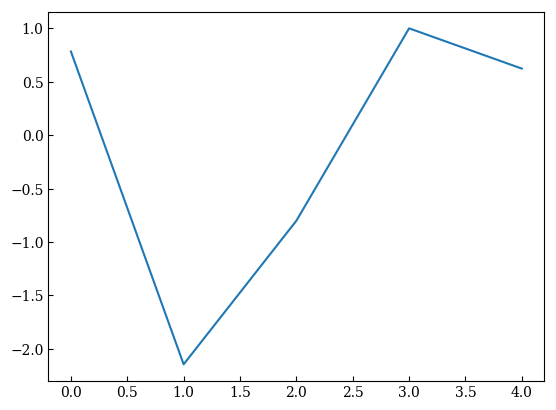

In [57]:
plot(randn(5))
tick_params(direction="in")

In [98]:
 Geom.hexbin(xbincount =100,ybincount = 100)
using Measures

UndefVarError: UndefVarError: Geom not defined

In [ ]:
module CornerPlot

using DataFrames
using Gadfly
using Compose
using Viridis
using Measures

export corner


function corner(samples::Union{Array{Float64}, AbstractDataFrame};
                bins::Union{Int, Array{Int, 1}, Array{Array{Float64, 1}, 1}} = 20,
                hexbins::Union{Int, Array{Int, 1}} = 50,
                range::Union{Array{Tuple{Float64,Float64}, 1}, Void} = nothing,
                varnames::Union{Array{String, 1}, Array{Symbol, 1}, Void} = nothing,
                truthvals::Union{Array{Float64, 1}, Array{Array{Float64, 1}}, Void} = nothing,
                ylabel_orientation::Symbol = :vertical,
                plotsize::Measures.Length{:mm,Float64} = 20cm)

    # If samples are in dataframe, get array of values
    if typeof(samples) <: AbstractDataFrame

        # only take relevant columns if given
        if typeof(varnames) == Array{Symbol, 1}
            samples = Array(samples[:, varnames])
        end

    # in case a 1-d array is passed
    elseif length(size(samples)) == 1
        samples = reshape(samples, (size(samples)[1], 1))
    end

    nsamps = size(samples)[1]
    ndims = size(samples)[2]

    if ndims > nsamps
        throw(ArgumentError("samples array should not have more dimensions than samples, try reshaping/transposing"))
    end

    # now to deal with bins
    if typeof(bins) == Int
        nbins = [bins for a in 1:ndims]

        if range != nothing
            bins = [linspace(r..., nbins[i]) for (i, r) in enumerate(range)]
        else
#            bins = nothing
            bins = [[minimum(samples[:, i]), maximum(samples[:, i])] for i in 1:ndims]
        end

    elseif typeof(bins) == Array{Int, 1}
        nbins = bins

        if range != nothing
            bins = [linspace(r..., nbins[i]) for (i, r) in enumerate(range)]
        else
#            bins = nothing
            bins = [[minimum(samples[:, i]), maximum(samples[:, i])] for i in 1:ndims]
        end

    else
        nbins = [length(a) - 1 for a in bins]
    end

    # and hexbins
    if typeof(hexbins) == Int
        hexbins = [hexbins for a in 1:ndims]
    end

    # set up the plots
    set_default_plot_size(plotsize, plotsize)
    subplots = Array{Context}(ndims, ndims)

    for i in 1:ndims

        # make an array for the layers of the plots
        diagarr = []

        # make a vertical line layer if requested
        if truthvals != nothing

            # turn a single array into an array of arrays
            if typeof(truthvals) == Array{Float64, 1}
                truthvals = [[val] for val in truthvals]
            end

            vline = layer(xintercept = truthvals[i], Geom.vline,
                          Theme(default_color = colorant"red"))
            append!(diagarr, vline)
        end

        # grab only those samples which will be in the plot range
        if bins != nothing
            histsamps = samples[:, i][bins[i][1] .<= samples[:, i] .< bins[i][end]]
        else
            histsamps = samples[:, i]
        end

        # this is the 1-d histogram layer
        append!(diagarr, layer(x = histsamps, Geom.histogram(bincount = nbins[i]),
                                Theme(default_color = Viridis.viridis(0.5))))

        # for last diagonal, add axis label if given
        xlabel = nothing
        ylabel = nothing
        if varnames != nothing
            if i == 1
                ylabel = String(varnames[i])
            elseif i == ndims
                xlabel = String(varnames[i])
            end
        end

        # and plot the diagonal histogram
        subplots[i, i] = render(plot(diagarr...,
                                     Guide.xlabel(nothing),
                                     Guide.ylabel(nothing),))

        # now loop over the subplots down the column
        for j in (i + 1):ndims

            # make layer array for each offdiagonal plot
            offdiag = []

            # add the horizontal and vertical lines
            if truthvals != nothing
                append!(offdiag, vline)
                hline = layer(yintercept = truthvals[j], Geom.hline,
                              Theme(default_color = colorant"red"))
                append!(offdiag, hline)
            end

            x=histsamps
            y=samples[:, j][bins[j][1] .<= samples[:, j] .< bins[j][end]]

            # get a hexbin layer
            append!(offdiag, layer(x=x, y=y,
                                   Geom.hexbin(xbincount = hexbins[i],
                                               ybincount = hexbins[j])))

            # and add the axis labels if given
            if varnames != nothing

                # ylabels only along the side
                if i == 1
                    ylabel = String(varnames[j])
                else
                    ylabel = nothing
                end

                # xlabels only along the bottom
                if j == ndims
                    xlabel = String(varnames[i])
                else
                    xlabel = nothing
                end

            else
                xlabel = nothing
                ylabel = nothing
            end

            # and plot the layers
            subplots[j, i] = render(plot(offdiag...,
                                    Scale.color_continuous(colormap = Viridis.viridis),
                                    Guide.xlabel(xlabel),
                                    Guide.ylabel(ylabel,
                                                 orientation = ylabel_orientation),
                                    Coord.Cartesian(xmin = bins[i][1], xmax = bins[i][end],
                                                    ymin = bins[j][1], ymax = bins[j][end]),
                                    Theme(key_position = :none)))

            # make subplots above diagonal empty
            subplots[i, j] = Compose.context()
        end
    end
    gridstack(subplots)
end

end

In [ ]:
hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())
ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

In [ ]:
pname = ["mu_1","P_1","t01","e1 cos(om1)","e1 sin(om1)",
            "mu_2","P_2","t02","e2 cos(om2)","e2 sin(om2)",
            "mu_3","P_3","t03","e3 cos(om3)","e3 sin(om3)",
            "tmax sin(phi0)","tmax cos(phi0)","deltaphi"]

In [233]:
function vectorize_data(include_moon::Bool=false)
    names = ["mu", "P", "t0", "e cos(om)", "e sin(om)"]
    planet = ["venus", "earth", "jupiter"]
    nparam = length(param)*nplanet+1
    state_total = zeros((nsteps-iburn)*nwalkers+50,nparam-1)
    for iparam=1:nparam-1
    state_total[:,iparam] += vec(par_mcmc[:,iburn:nsteps,iparam])
    if iparam < nparam
            pname = string(planet[div(iparam-1,5)+1]," ",names[mod(iparam-1,5)+1])
    end
    #     println("index: ",iparam, " ",pname," : ",pbest_global[iparam])
    end
end
# mu1,P1,t01,ecos1,esin1 = pbest_global[1:5]
# mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
# mu3,P3,t03,ecos3,esin3 = pbest_global[11:15]
# scatter(vec(par_mcmc[1:nwalkers,1:nsteps,1]),vec(par_mcmc[1:nwalkers,1:nsteps,5]))

## MCMC steps and parameters

In [ ]:
function plot_mcmc(include_moon::Bool=false)
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i])
    ylabel(pname[i])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp1.png")
    clf()
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i+5])
    ylabel(pname[i+5])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp2.png")
    clf()
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i+10])
    ylabel(pname[i+10])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp3.png")
    clf()
    if include_moon
        figsize=(5,3)
        for i=1:3
        subplot(3,1,i)
        for j=1:nwalkers 
        plot(par_mcmc[j,1:nsteps,i+15])
        ylabel(pname[i+15])
        end
        # tight_layout()
        end
        name = string("IMAGES/MCMCstepsmoon.png")
    end
savefig(name)
end
# Make plot of MCMC parameters after burn-in
# figsize=(8,6)
# for i=2:nparam
#   for j=1:i-1
#     scatter(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]),vec(par_mcmc[1:nwalkers,iburn:nsteps,j]))
#     xlabel(pname[i])
#     ylabel(pname[j])
#   end
# end
# name = string("IMAGES/MCMCparams",label,".png")

## 3 Planet then Moon Fit without EMB

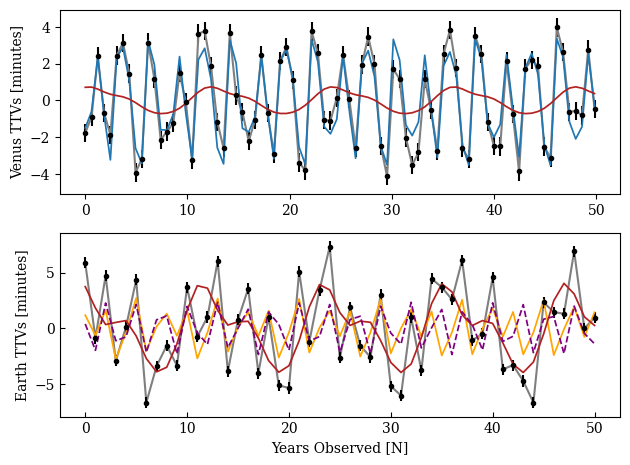

In [13]:
@load ("OUTPUTS/moon_fitmtry1params.jld2")
@load ("mcmc_mtry1results.jld2") 
plot_ttvs(true)

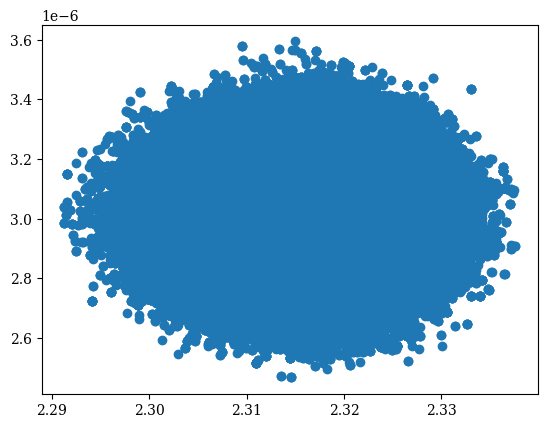

PyObject <matplotlib.collections.PathCollection object at 0x13b98cb50>

In [15]:
scatter(vec(par_mcmc[:,:,18]),vec(par_mcmc[:,:,6]))